<a href="https://colab.research.google.com/github/bndxn/dissertation/blob/main/Model_8_ConvLSTM%2C_PV_and_Sat_diff_timestamps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tqdm
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/dissertation')

Mounted at /content/drive


In [2]:
training_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_train.npy')
training_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_train.npy')

test_sat_images = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_images_test.npy')
test_sat_times = np.load('/content/drive/My Drive/Colab Notebooks/dissertation/Model 4/sat_times_test.npy')
pv_df = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/dissertation/uk_pv/devon_pv_readings.pkl")
pv_df = pv_df.iloc[:,-1] # Only taking the means

print(pv_df.shape)
print(training_sat_images.shape)
print(training_sat_times.shape)
print(test_sat_images.shape)
print(test_sat_times.shape)

(233458,)
(24146, 128, 128)
(24146,)
(10139, 128, 128)
(10139,)


In [3]:
def pv_readings_for_sat_times(selected_sat_times, pv_readings_series):

  pv_readings_for_sat_times = []

  for time in selected_sat_times:
    try:
      reading = pv_readings_series[pv_readings_series.index == time][0]
      pv_readings_for_sat_times.append(reading)
    except IndexError:
      pv_readings_for_sat_times.append(0)
  
  pv_readings_for_sat_times = np.asarray(pv_readings_for_sat_times, dtype=object).astype('float32')

  np.nan_to_num(pv_readings_for_sat_times, copy=False)

  return pv_readings_for_sat_times

train_pv = pv_readings_for_sat_times(training_sat_times, pv_df)
test_pv = pv_readings_for_sat_times(test_sat_times, pv_df)

In [39]:
def get_list_of_days(list_of_timestamps):

  list_of_days = []

  for i in list_of_timestamps:
    list_of_days.append(pd.Timestamp(i).date())

  return list(dict.fromkeys(list_of_days))


def get_blocks_of_timestamps_for_day(date, list_of_timestamps, n_slices_per_block, blocks_ahead):

  timestamps_in_day = []

  for i in list_of_timestamps: # Inefficient, checks all timestamps
    if pd.Timestamp(i).date() == date:
      timestamps_in_day.append(i)

  blocks_in_day = (len(timestamps_in_day) // n_slices_per_block) - blocks_ahead # subtracting so there's more time at the end of the day to predict - but I guess this shortens the day...

  block_list = []

  for i in range(blocks_in_day):
    block_list.append(timestamps_in_day[i*n_slices_per_block:(i+1)*n_slices_per_block])

  return np.asarray(block_list)

def get_pv_and_sat_blocks(block_list, sat_data, pv_data, list_of_timestamps, n_slices_per_block, blocks_ahead):

  sat_readings = np.zeros(shape=(len(block_list), n_slices_per_block, 128, 128)) 
  pv_readings = np.zeros(shape=(len(block_list), n_slices_per_block)) 

  for i in range(block_list.shape[0]):
    for j in range(block_list.shape[1]):
      timestamp = block_list[i,j]

      index = np.where(list_of_timestamps == timestamp)[0][0]
      sat_readings[i,j] = sat_data[index]    
      pv_readings[i,j] = pv_data[index+(n_slices_per_block*blocks_ahead)]  # predicting values forward

  return sat_readings, pv_readings

def bundle_data(list_of_timestamps, sat_images, pv_data, n_slices_per_block, blocks_ahead):

  list_of_days = get_list_of_days(list_of_timestamps)

  sat_readings_list = []
  pv_readings_list = []

  for day in list_of_days:

    block_list = get_blocks_of_timestamps_for_day(day, list_of_timestamps, n_slices_per_block, blocks_ahead)
    sat_readings, pv_readings = get_pv_and_sat_blocks(block_list, sat_images, pv_data, list_of_timestamps, n_slices_per_block, blocks_ahead)
    
    sat_readings_list.append(sat_readings)
    pv_readings_list.append(pv_readings)

  sat_readings = np.concatenate(sat_readings_list)
  pv_readings = np.concatenate(pv_readings_list)

  return sat_readings, pv_readings

In [40]:
sat_train, pv_train = bundle_data(training_sat_times, training_sat_images, train_pv, n_slices_per_block=12, blocks_ahead=2)
sat_test, pv_test = bundle_data(test_sat_times, test_sat_images, test_pv, n_slices_per_block=12, blocks_ahead=2)

sat_test /= 255
sat_train  /= 255

sat_train = np.expand_dims(sat_train, axis=-1)
sat_test = np.expand_dims(sat_test, axis=-1)

max = np.maximum(np.nanmax(pv_train), np.nanmax(pv_test))

pv_test /= (max + 1)
pv_train /=  (max + 1)

from sklearn import utils

sat_train_shuffle, pv_train_shuffle  = utils.shuffle(sat_train, pv_train)
sat_test_shuffle, pv_test_shuffle = utils.shuffle(sat_test, pv_test)


print(sat_train_shuffle.shape)
print(pv_train_shuffle.shape)

print(sat_test_shuffle.shape)
print(pv_test_shuffle.shape)

(1706, 12, 128, 128, 1)
(1706, 12)
(720, 12, 128, 128, 1)
(720, 12)


In [26]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

inp = layers.Input(shape=(sat_train.shape[1:]))

x = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(inp)
x = layers.MaxPooling3D(pool_size=(1,2,2))(x)

x = layers.ConvLSTM2D(filters=10, kernel_size=(3,3), return_sequences=True) (x)
x = layers.MaxPooling3D(pool_size=(1,3,3))(x)

x = layers.ConvLSTM2D(filters=5, kernel_size=(3,3), return_sequences=False, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(12, activation='linear')(x) 


model = keras.models.Model(inp, x)
model.compile(
    loss='mse', optimizer=keras.optimizers.Adam(),
)

In [27]:
# Training hyperparameters
epochs = 5
batch_size = 5

# Fit the model to the training data.
history = model.fit(
    sat_train_shuffle,
    pv_train_shuffle,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(sat_test_shuffle, pv_test_shuffle)
)

Epoch 1/5
342/342 [==============================] - 83s 225ms/step - loss: 0.0436 - val_loss: 0.0370 - lr: 0.0010
Epoch 2/5
342/342 [==============================] - 76s 222ms/step - loss: 0.0308 - val_loss: 0.0293 - lr: 0.0010
Epoch 3/5
342/342 [==============================] - 76s 222ms/step - loss: 0.0242 - val_loss: 0.0253 - lr: 0.0010
Epoch 4/5
342/342 [==============================] - 77s 225ms/step - loss: 0.0204 - val_loss: 0.0243 - lr: 0.0010
Epoch 5/5
342/342 [==============================] - 76s 222ms/step - loss: 0.0176 - val_loss: 0.0213 - lr: 0.0010


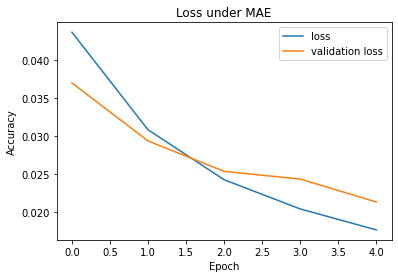

In [28]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Loss under MAE')
plt.legend();


In [29]:
model.predict(np.expand_dims(sat_test[0], axis=0))

array([[0.02423251, 0.02353873, 0.01819158, 0.01931261, 0.02717613,
        0.03529948, 0.0292765 , 0.02857072, 0.02559735, 0.03602812,
        0.03228715, 0.03780639]], dtype=float32)

In [33]:
two_hr_predictions = []

for i in range(100):

  predictions = model.predict(np.expand_dims(sat_test[i], axis=0))
  last_prediction = np.squeeze(predictions)[-1]
  two_hr_predictions.append(last_prediction)

print(two_hr_predictions)


[0.037806388, 0.037806388, 0.19338812, 0.118880436, 0.11969544, 0.11443786, 0.12222706, 0.11593494, 0.06366716, 0.048078857, 0.037806388, 0.037806388, 0.037806388, 0.037360843, 0.17253906, 0.105481416, 0.1260021, 0.13708076, 0.12668009, 0.24609539, 0.038305227, 0.037806388, 0.037806388, 0.037806388, 0.037806388, 0.0374295, 0.26749757, 0.13009346, 0.35778415, 0.3332364, 0.14475344, 0.0550746, 0.1310231, 0.037806388, 0.037806388, 0.037806388, 0.037806388, 0.1889965, 0.15642855, 0.13958742, 0.1754058, 0.18966988, 0.22136293, 0.36571538, 0.2437339, 0.037806388, 0.037806388, 0.037806388, 0.037806388, 0.23184876, 0.38534236, 0.46401227, 0.55007195, 0.6130058, 0.4376707, 0.21222521, 0.13499829, 0.08900586, 0.037806388, 0.037806388, 0.039646834, 0.16992423, 0.22437225, 0.21475437, 0.23557243, 0.21962543, 0.2046367, 0.24565989, 0.13725077, 0.04292055, 0.03697292, 0.037806388, 0.2435166, 0.38135043, 0.4072389, 0.5759914, 0.58748853, 0.61856157, 0.5627927, 0.4745591, 0.30621433, 0.18831144, 0.138

In [19]:
pv_test.shape

(900, 10)

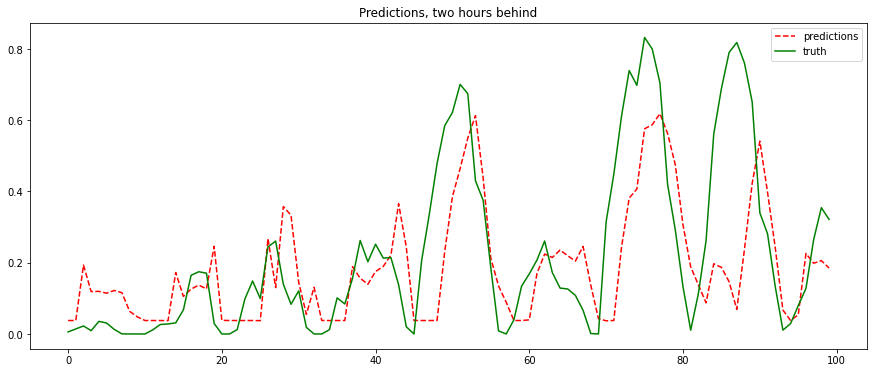

In [38]:
fig = plt.figure(figsize=(15,6))
plt.plot(np.arange(len(two_hr_predictions)), two_hr_predictions, '--', color='red', label='predictions')
plt.plot(np.arange(len(two_hr_predictions)), pv_test[2:102,0], color='green', label='truth')
plt.title('Predictions, two hours behind')
plt.legend();



In [41]:
sat_train, pv_train = bundle_data(training_sat_times, training_sat_images, train_pv, n_slices_per_block=12, blocks_ahead=1)
sat_test, pv_test = bundle_data(test_sat_times, test_sat_images, test_pv, n_slices_per_block=12, blocks_ahead=1)

sat_test /= 255
sat_train  /= 255

sat_train = np.expand_dims(sat_train, axis=-1)
sat_test = np.expand_dims(sat_test, axis=-1)

max = np.maximum(np.nanmax(pv_train), np.nanmax(pv_test))

pv_test /= (max + 1)
pv_train /=  (max + 1)

from sklearn import utils

sat_train_shuffle, pv_train_shuffle  = utils.shuffle(sat_train, pv_train)
sat_test_shuffle, pv_test_shuffle = utils.shuffle(sat_test, pv_test)


print(sat_train_shuffle.shape)
print(pv_train_shuffle.shape)

print(sat_test_shuffle.shape)
print(pv_test_shuffle.shape)

(1852, 12, 128, 128, 1)
(1852, 12)
(780, 12, 128, 128, 1)
(780, 12)


In [42]:
inp = layers.Input(shape=(sat_train.shape[1:]))

x = layers.ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(inp)
x = layers.MaxPooling3D(pool_size=(1,2,2))(x)

x = layers.ConvLSTM2D(filters=10, kernel_size=(3,3), return_sequences=True) (x)
x = layers.MaxPooling3D(pool_size=(1,3,3))(x)

x = layers.ConvLSTM2D(filters=5, kernel_size=(3,3), return_sequences=False, activation="relu") (x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(12, activation='linear')(x) 


model = keras.models.Model(inp, x)
model.compile(
    loss='mse', optimizer=keras.optimizers.Adam(),
)

In [43]:
# Training hyperparameters
epochs = 5
batch_size = 5

# Fit the model to the training data.
history = model.fit(
    sat_train_shuffle,
    pv_train_shuffle,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(sat_test_shuffle, pv_test_shuffle)
)

Epoch 1/5
371/371 [==============================] - 95s 237ms/step - loss: 0.0329 - val_loss: 0.0231
Epoch 2/5
371/371 [==============================] - 84s 227ms/step - loss: 0.0180 - val_loss: 0.0142
Epoch 3/5
371/371 [==============================] - 84s 227ms/step - loss: 0.0132 - val_loss: 0.0120
Epoch 4/5
371/371 [==============================] - 84s 227ms/step - loss: 0.0115 - val_loss: 0.0138
Epoch 5/5
371/371 [==============================] - 84s 226ms/step - loss: 0.0107 - val_loss: 0.0121


In [44]:
one_hr_predictions = []

for i in range(100):

  predictions = model.predict(np.expand_dims(sat_test[i], axis=0))
  last_prediction = np.squeeze(predictions)[-1] # Throws away all but the last prediction
  one_hr_predictions.append(last_prediction)

# print(one_hr_predictions)


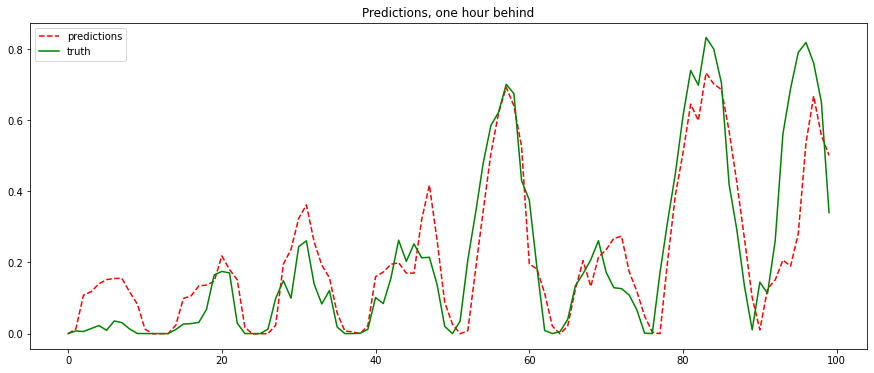

In [45]:
fig = plt.figure(figsize=(15,6))
plt.plot(np.arange(len(one_hr_predictions)), one_hr_predictions, '--', color='red', label='predictions')
plt.plot(np.arange(len(one_hr_predictions)), pv_test[1:101,0], color='green', label='truth')
plt.title('Predictions, one hour behind')
plt.legend();

